# Collaborative Filtering: Pearson Correlation
### Katelyn Stringer, April 14, 2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import predict_full, train_test_split, mse
import time
import seaborn as sns
%matplotlib inline

### Read in and format the data

In [2]:
ratings = pd.read_csv('data/ratings.csv',header=0)
ratings.tail()

,userId,movieId,rating,timestamp
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663
100003,671,6565,3.5,1074784724


In [3]:
### Sort the values
ratings.sort_values('userId',inplace=True)
print(len(ratings))

100004


We see that the format of this data is a row per rating with 4 columns. We need to reshape this into a useful matrix format to build our recommendation engine. We can use pivot for this.

In [4]:
ratings = ratings.pivot_table(index='movieId',columns='userId',values='rating')
ratings.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


### Calculate similarity between users

Now we have a really sparse matrix indexed by movieId, filled with all of the ratings values for each user (columns). Since we set the users as columns, we can use pandas' "corr" function to determine the correlation between different users.

In [5]:
sim = ratings.corr()
sim.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.068752,NaN,NaN,-0.912871,NaN,NaN,NaN,...,NaN,NaN,1.000000,0.132453,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.000000,0.000000,-0.070244,0.283473,NaN,0.302032,-0.044901,0.000000,-1.000000,...,-0.042903,-1.0,0.296117,-0.368922,0.052083,-0.224189,-0.500000,-1.000000,-0.648204,0.460239
3,NaN,0.000000,1.000000,NaN,-0.170881,-1.000000,0.188056,0.061023,-0.580948,0.559017,...,0.143420,NaN,0.506024,0.114808,0.655596,0.699260,-0.693375,0.970725,-0.218218,0.354044
4,0.068752,-0.070244,NaN,1.000000,0.084827,0.434057,0.270274,0.471954,NaN,NaN,...,0.179664,NaN,0.181856,0.356573,0.254491,0.600736,0.577350,0.270765,0.027639,0.131904
5,NaN,0.283473,-0.170881,0.084827,1.000000,0.333333,-0.559017,-0.181601,0.261116,1.000000,...,0.389156,NaN,0.002655,0.180346,-0.369175,-0.408248,NaN,NaN,-0.632456,-0.186872


This returned a 671x671 matrix showing how the different users are correlated to each other. Note all of the NaN's where there were insufficient overlapping ratings for the same movies to calculate the correlations.

### Predict movie ratings for one user

Now let's try to fill in some of the missing values for each user based on the similarity to other users. First, we extract the first user and the similarity values.

In [6]:
user1 = ratings[1]
print(user1.head())

### Locate all movies that this user rated and ignore nans.
moviesrated = np.unique(user1[user1.values>0].index)
print(len(user1),len(moviesrated))
print(moviesrated[:5])

movieId
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: 1, dtype: float64
9066 20
[  31 1029 1061 1129 1172]


In [7]:
### Pull out the rows for the movies not rated by user 1.
unknown_movies = ratings[~ratings.index.isin(moviesrated)]
print(unknown_movies.head())
print(len(unknown_movies))

userId   1    2    3    4    5    6    7    8    9    10  ...   662  663  664  \
movieId                                                   ...                   
1        NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  4.0  NaN ...   NaN  4.0  3.5   
2        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   5.0  NaN  NaN   
3        NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
5        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   

userId   665  666  667  668  669  670  671  
movieId                                     
1        NaN  NaN  NaN  NaN  NaN  4.0  5.0  
2        3.0  NaN  NaN  NaN  NaN  NaN  NaN  
3        3.0  NaN  NaN  NaN  NaN  NaN  NaN  
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5        3.0  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 671 columns]
9046


In [8]:
### Pull out similarities to other users for this one user
tempsim = sim.iloc[0]
tempsim.head()

userId
1    1.000000
2         NaN
3         NaN
4    0.068752
5         NaN
Name: 1, dtype: float64

In [9]:
### Multiply these movies by the weights from other users
temp_weights = np.transpose(tempsim)*unknown_movies
temp_weights.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,-2.738613,NaN,NaN,NaN,...,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
### Sum up all of the weights for each row
temp_weights['sum'] = temp_weights.sum(axis=1)
temp_weights.head()

userId,1,2,3,4,5,6,7,8,9,10,...,663,664,665,666,667,668,669,670,671,sum
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,-2.738613,NaN,NaN,NaN,...,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.969611
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,-4.782301
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,12.136257
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.919123
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,-3.459428


In [11]:
### Make a mask of NaNs to apply to sim matrix
nanmask = np.isfinite(temp_weights)*1
nansim = np.transpose(tempsim)*nanmask
print(nansim.head())

### Notice that the Nan values now do not have a similarity weight.

/Users/alexanderriley/miniconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py:3140: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


userId   1    2    3  4    5    6         7    8    9   10 ...   663 664  \
movieId                                                    ...             
1        0  NaN  NaN  0  NaN  NaN -0.912871  NaN  NaN  NaN ...   NaN   1   
2        0  NaN  NaN  0  NaN  NaN        -0  NaN  NaN  NaN ...   NaN   0   
3        0  NaN  NaN  0  NaN  NaN        -0  NaN  NaN  NaN ...   NaN   0   
4        0  NaN  NaN  0  NaN  NaN        -0  NaN  NaN  NaN ...   NaN   0   
5        0  NaN  NaN  0  NaN  NaN        -0  NaN  NaN  NaN ...   NaN   0   

userId        665  666  667  668  669  670  671  sum  
movieId                                               
1               0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2        0.132453  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3        0.132453  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4               0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5        0.132453  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 672 columns]


In [12]:
### Tack on weights to end of movie matrix
temp_weights['sumweights'] = nansim.sum(axis=1)
temp_weights.head()

userId,1,2,3,4,5,6,7,8,9,10,...,664,665,666,667,668,669,670,671,sum,sumweights
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,-2.738613,NaN,NaN,NaN,...,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.969611,1.194460
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,-4.782301,-0.483368
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,12.136257,2.562949
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.919123,-0.305628
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,-3.459428,-0.945392


In [13]:
### Estimate the ratings for this user and record the sample size of the estimate (larger numbers means better statistics)
temp_weights['pred'] = [float(a)/b for a,b in zip(temp_weights['sum'],temp_weights['sumweights'])]
temp_weights['pred'].head()
temp_weights['size'] = temp_weights.count(axis=1) ## counts the number of non-Nan values in a row

ZeroDivisionError: float division by zero

In [14]:
temp_weights.head()

userId,1,2,3,4,5,6,7,8,9,10,...,664,665,666,667,668,669,670,671,sum,sumweights
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,-2.738613,NaN,NaN,NaN,...,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.969611,1.194460
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,-4.782301,-0.483368
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,12.136257,2.562949
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.919123,-0.305628
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.39736,NaN,NaN,NaN,NaN,NaN,NaN,-3.459428,-0.945392


Let's get rid of any crazy values. Clearly, if the value is below zero, we can assume the rating would be zero in real life on the 0-5 scale. The same goes for values above 5.

In [15]:
### Set negative values to zero
temp_weights['pred'].loc[temp_weights['pred']<0]=0
### Set large positive values to 5
temp_weights['pred'].loc[temp_weights['pred']>5]=5

KeyError: 'pred'

KeyError: 'pred'

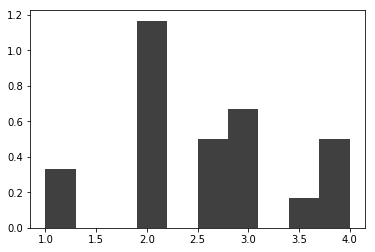

In [16]:
### Take a look at the ratings compared to the ones the user already had
plt.hist(user1.dropna(),color='black',histtype='stepfilled',normed=True,bins=10,alpha=0.75)
plt.hist(temp_weights['pred'].dropna(),color='red',histtype='stepfilled',normed=True,bins=10,alpha=0.75)

It is unfortunate that this user rated so sparsely as it looks like the recommendation system skewed recommendations far more postively than the user actually rated movies in real life. Now that we understand how the nuts and bolts of this work, let's test this on a larger scale using the functions in utils.py

## Test on a wider scale

In [27]:
### First, let's split the data into a training and test set
### To be consistent with the notation of my partner, I need to switch the row and column placement
ratings_filled = ratings.transpose()
train, test = train_test_split(ratings_filled, empty=0.0, testfrac=0.2)

In [28]:
### Check that ~80% of the ratings are in the training set per movie
(train.astype(bool).sum(axis=1)/ratings_filled.astype(bool).sum(axis=1)).head(n=7)

userId
1    0.800000
2    0.802632
3    0.803922
4    0.803922
5    0.800000
6    0.818182
7    0.806818
dtype: float64

In [29]:
### Find the similarity matrix for our training data
st = time.time()
sim_train = train.transpose().corr() ### pandas corr finds correlation for columns not rows
print('Time to calculate similarity:',time.time()-st)

Time to calculate similarity: 7.9937708377838135


In [30]:
### Use the similarity matrix to predict movie ratings
st = time.time()
prediction = predict_full(train, sim_train.transpose().values)
print('Time to train:',time.time()-st)

Time to train: 0.5251147747039795


/Users/alexanderriley/Github/movie-matchmaker/utils.py:19: RuntimeWarning: invalid value encountered in true_divide
  pred = weights.dot(rates) / np.abs(weights).dot(rates.mask(rates>0, other=1.0))


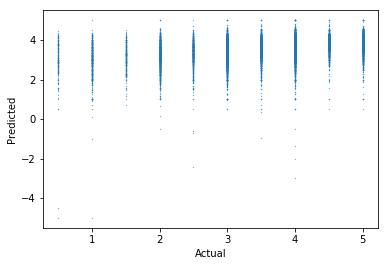

In [31]:
### Let's check this to see how we did
plt.plot(test.values[test.values > 0], prediction.values[test.values > 0], '.', ms=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted');

In [24]:
fs = 22
plt.figure(figsize=(18,14))
with sns.axes_style("white"):
    t = sns.jointplot(x=test.values[test.values > 0], y=prediction.values[test.values > 0], kind="hex", color="k", gridsize=30)
    plt.savefig('./pearson_pred.png')
    plt.clf()
    #plt.xlabel('Actual Values',size=fs)
    #plt.ylabel('Predicted Values',size=fs)

Text(336.971,0.5,'Predicted Values')

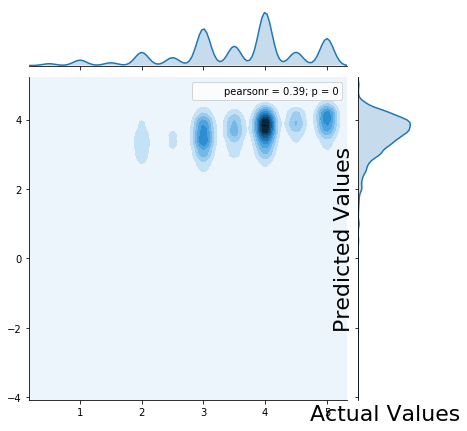

In [25]:
fs = 22
plt.figure(figsize=(18,14))
sns.jointplot(x=test.values[test.values > 0], y=prediction.values[test.values > 0], kind="kde")
plt.xlabel('Actual Values',size=fs)
plt.ylabel('Predicted Values',size=fs)

In [32]:
### So this looks pretty bad. Let's quantify how bad
mse(pred=prediction, actual=test)

0.9633515976947803

Actually, this is fairly comparable to our other cosine similarity metric.

## Time to test this on myself!

In [52]:
### Read in my ratings
mine = pd.read_csv('processed/katelyn_ratings.csv',header=0)

In [53]:
mine.head()

,movieId,ratings
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0


In [54]:
### Reformat my file so I can append to the end of the ratings

mine['movieId'] = [int(a) for a in mine['movieId']]
mine['userId'] = 'me'
mine['rating'] = mine['ratings']
mine['timestamp'] = 0
mine = pd.DataFrame({'userId':mine['userId'],'movieId':mine['movieId'],'rating':mine['rating'],'timestamp':mine['timestamp']})


In [55]:
### Remove all the empty rows of movies I hadn't seen
mine = mine.loc[mine['movieId']>0]
len(mine)

26

In [95]:
mine

,movieId,rating,timestamp,userId
19,7444,4.5,0,me
51,8814,1.0,0,me
137,81018,5.0,0,me
146,5989,5.0,0,me
147,46970,3.0,0,me
152,143385,5.0,0,me
156,915,1.5,0,me
164,52694,4.0,0,me
169,5629,4.5,0,me
175,72407,3.0,0,me


In [56]:
### Read in the raw rating file again
ratings = pd.read_csv('data/ratings.csv',header=0)

In [57]:
### Append my ratings to the end of the ratings file
ratings = pd.concat([ratings,mine],ignore_index=True)

In [58]:
ratings.tail()

,movieId,rating,timestamp,userId
100025,1381,2.0,0,me
100026,138036,4.5,0,me
100027,145935,3.0,0,me
100028,5096,3.0,0,me
100029,34162,3.5,0,me


In [59]:
#### Yep, they are definitely there!

ratings = ratings.pivot_table(index='movieId',columns='userId',values='rating')
ratings.head()

userId,1,2,3,4,5,6,7,8,9,10,...,663,664,665,666,667,668,669,670,671,me
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
sim = ratings.corr()
sim.head()

userId,1,2,3,4,5,6,7,8,9,10,...,663,664,665,666,667,668,669,670,671,me
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.068752,NaN,NaN,-0.912871,NaN,NaN,NaN,...,NaN,1.000000,0.132453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.000000,0.000000,-0.070244,0.283473,NaN,0.302032,-0.044901,0.000000,-1.000000,...,-1.0,0.296117,-0.368922,0.052083,-0.224189,-0.500000,-1.000000,-0.648204,0.460239,NaN
3,NaN,0.000000,1.000000,NaN,-0.170881,-1.000000,0.188056,0.061023,-0.580948,0.559017,...,NaN,0.506024,0.114808,0.655596,0.699260,-0.693375,0.970725,-0.218218,0.354044,NaN
4,0.068752,-0.070244,NaN,1.000000,0.084827,0.434057,0.270274,0.471954,NaN,NaN,...,NaN,0.181856,0.356573,0.254491,0.600736,0.577350,0.270765,0.027639,0.131904,NaN
5,NaN,0.283473,-0.170881,0.084827,1.000000,0.333333,-0.559017,-0.181601,0.261116,1.000000,...,NaN,0.002655,0.180346,-0.369175,-0.408248,NaN,NaN,-0.632456,-0.186872,-1.0


In [61]:
me = ratings['me']
print(me.head())

### Locate all movies that I rated and ignore nans.
moviesrated = np.unique(me[me.values>0].index)
print(len(me),len(moviesrated))
print(moviesrated[:5])

movieId
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
Name: me, dtype: float64
9066 26
[ 575  915 1381 3916 5096]


C:\Users\hooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [62]:
### Pull out the rows for the movies I didn't rate.
unknown_movies = ratings[~ratings.index.isin(moviesrated)]
print(unknown_movies.head())
print(len(unknown_movies))

userId    1   2   3   4    5   6    7   8    9  10 ...  663  664  665  666  \
movieId                                            ...                       
1       NaN NaN NaN NaN  NaN NaN  3.0 NaN  4.0 NaN ...  4.0  3.5  NaN  NaN   
2       NaN NaN NaN NaN  NaN NaN  NaN NaN  NaN NaN ...  NaN  NaN  3.0  NaN   
3       NaN NaN NaN NaN  4.0 NaN  NaN NaN  NaN NaN ...  NaN  NaN  3.0  NaN   
4       NaN NaN NaN NaN  NaN NaN  NaN NaN  NaN NaN ...  NaN  NaN  NaN  NaN   
5       NaN NaN NaN NaN  NaN NaN  NaN NaN  NaN NaN ...  NaN  NaN  3.0  NaN   

userId   667  668  669  670  671  me  
movieId                               
1        NaN  NaN  NaN  4.0  5.0 NaN  
2        NaN  NaN  NaN  NaN  NaN NaN  
3        NaN  NaN  NaN  NaN  NaN NaN  
4        NaN  NaN  NaN  NaN  NaN NaN  
5        NaN  NaN  NaN  NaN  NaN NaN  

[5 rows x 672 columns]
9040


In [63]:
### Pull out my similarities to other users
tempsim = sim.iloc[-1]
tempsim.head()

userId
1    NaN
2    NaN
3    NaN
4    NaN
5   -1.0
Name: me, dtype: float64

In [64]:
### Multiply these movies by the weights from other users
temp_weights = np.transpose(tempsim)*unknown_movies
temp_weights.head()

userId,1,2,3,4,5,6,7,8,9,10,...,663,664,665,666,667,668,669,670,671,me
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.175882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,-4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
### Sum up all of the weights for each row
temp_weights['sum'] = temp_weights.sum(axis=1)
temp_weights.head()

userId,1,2,3,4,5,6,7,8,9,10,...,664,665,666,667,668,669,670,671,me,sum
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.175882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.367757
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.636848
3,NaN,NaN,NaN,NaN,-4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.190546
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.417367
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.201300


In [66]:
### Make a mask of NaNs to apply to sim matrix
nanmask = np.isfinite(temp_weights)*1
nansim = np.transpose(tempsim)*nanmask
print(nansim.head())

userId    1   2   3   4    5   6   7   8   9  10 ...        664  665  666  \
movieId                                          ...                        
1       NaN NaN NaN NaN -0.0 NaN NaN NaN NaN NaN ...  -0.050252  NaN  NaN   
2       NaN NaN NaN NaN -0.0 NaN NaN NaN NaN NaN ...  -0.000000  NaN  NaN   
3       NaN NaN NaN NaN -1.0 NaN NaN NaN NaN NaN ...  -0.000000  NaN  NaN   
4       NaN NaN NaN NaN -0.0 NaN NaN NaN NaN NaN ...  -0.000000  NaN  NaN   
5       NaN NaN NaN NaN -0.0 NaN NaN NaN NaN NaN ...  -0.000000  NaN  NaN   

userId   667  668  669  670  671   me  sum  
movieId                                     
1        NaN  NaN  NaN  NaN  NaN  0.0  NaN  
2        NaN  NaN  NaN  NaN  NaN  0.0  NaN  
3        NaN  NaN  NaN  NaN  NaN  0.0  NaN  
4        NaN  NaN  NaN  NaN  NaN  0.0  NaN  
5        NaN  NaN  NaN  NaN  NaN  0.0  NaN  

[5 rows x 673 columns]


C:\Users\hooja\Anaconda3\lib\site-packages\pandas\core\generic.py:4513: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  return_indexers=True)


In [67]:
### Tack on weights to end of movie matrix
temp_weights['sumweights'] = nansim.sum(axis=1)
temp_weights.head()

userId,1,2,3,4,5,6,7,8,9,10,...,665,666,667,668,669,670,671,me,sum,sumweights
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.367757,19.048601
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.636848,1.750847
3,NaN,NaN,NaN,NaN,-4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.190546,0.831540
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.417367,-0.944911
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.201300,2.292271


In [68]:
### Estimate the ratings for this user and record the sample size of the estimate (larger numbers means better statistics)
temp_weights['pred'] = [float(a)/b for a,b in zip(temp_weights['sum'],temp_weights['sumweights'])]
temp_weights['pred'].head()
temp_weights['size'] = temp_weights.count(axis=1) ## counts the number of non-Nan values in a row

C:\Users\hooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\hooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


In [69]:
temp_weights.head()

userId,1,2,3,4,5,6,7,8,9,10,...,667,668,669,670,671,me,sum,sumweights,pred,size
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,69.367757,19.048601,3.641620,78
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.636848,1.750847,1.506042,39
3,NaN,NaN,NaN,NaN,-4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.190546,0.831540,-2.634323,18
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-3.417367,-0.944911,3.616601,6
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.201300,2.292271,2.705308,19


In [79]:
temp_weights['pred']

movieId
1         3.641620
2         1.506042
3        -2.634323
4         3.616601
5         2.705308
6         3.745207
7         0.134458
8              NaN
9              inf
10        3.652564
11        4.787699
12        1.446990
13        4.417447
14        0.340483
15        3.261584
16        3.153367
17        4.128815
18        2.313785
19        1.329769
20        1.707812
21        2.672048
22        2.746864
23        2.692392
24        2.829212
25        1.169193
26        3.500000
27        1.666667
28        3.508854
29       -4.229556
30        2.500000
            ...   
158238    3.761867
158314    4.500000
158528    3.500000
158956         NaN
159093    1.000000
159462    3.000000
159690    2.000000
159755    1.000000
159858    3.738133
159972    0.500000
160080    1.000000
160271    2.500000
160438    4.500000
160440    1.500000
160563    6.825209
160565    2.000000
160567    4.000000
160590    5.000000
160656    3.500000
160718    4.000000
161084    2.500000
1611

In [76]:
### Unpivot the table for easier usage
recs = pd.melt(temp_weights,var_name='movieId',value_name='pred',col_level=0)

In [70]:
### Read in the movie file to see what the titles are:
movies = pd.read_csv('data/movies.csv',header=0)

In [71]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [83]:
recs = movies.join(temp_weights['pred'],on='movieId',how='inner')#temp_weights[['movieId','pred','size']].merge(movies,on='movieId', how='inner')

In [87]:
recs.head()

,movieId,title,genres,pred
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.641620
1,2,Jumanji (1995),Adventure|Children|Fantasy,1.506042
2,3,Grumpier Old Men (1995),Comedy|Romance,-2.634323
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3.616601
4,5,Father of the Bride Part II (1995),Comedy,2.705308


In [90]:
### Replace crazy values
recs.replace(np.inf,0,inplace=True)
recs.replace(-1*np.inf,0,inplace=True)

In [93]:
### Let's see the top predicted movies for me
recs.sort_values('pred',ascending=False).iloc[:25]


,movieId,title,genres,pred
1785,2259,Blame It on Rio (1984),Comedy|Romance,233.895673
6853,56715,Wristcutters: A Love Story (2006),Drama|Fantasy|Romance,188.125901
1057,1304,Butch Cassidy and the Sundance Kid (1969),Action|Western,158.478853
3616,4603,Her Alibi (1989),Comedy|Romance,151.966871
3884,5010,Black Hawk Down (2001),Action|Drama|War,128.827033
619,741,Ghost in the Shell (Kôkaku kidôtai) (1995),Animation|Sci-Fi,122.051226
8144,96829,"Hunt, The (Jagten) (2012)",Drama,95.649756
948,1190,Tie Me Up! Tie Me Down! (¡Átame!) (1990),Crime|Drama|Romance,83.622731
1979,2473,Soul Man (1986),Comedy,82.686270
2505,3113,End of Days (1999),Action|Fantasy|Horror|Mystery|Thriller,80.446029


In [94]:
#### uhhhh ok, let's look at the worse ones
recs.sort_values('pred',ascending=True).iloc[:25]



,movieId,title,genres,pred
7004,60684,Watchmen (2009),Action|Drama|Mystery|Sci-Fi|Thriller|IMAX,-1916.952258
6937,59126,Religulous (2008),Comedy|Documentary,-612.391192
6503,47518,Accepted (2006),Comedy,-530.301208
899,1120,"People vs. Larry Flynt, The (1996)",Comedy|Drama,-445.661452
8052,94780,Snow White and the Huntsman (2012),Action|Adventure|Drama,-212.869539
6572,49274,Happy Feet (2006),Adventure|Animation|Children|Comedy|IMAX,-107.213206
537,610,Heavy Metal (1981),Action|Adventure|Animation|Horror|Sci-Fi,-86.651489
1040,1286,Somewhere in Time (1980),Drama|Romance,-78.978196
1695,2137,Charlotte's Web (1973),Animation|Children,-70.944376
7700,82854,Gulliver's Travels (2010),Adventure|Comedy|Fantasy,-65.466429


Well, that's special. I happen to really like Watchmen...

In [97]:
### A final check of what I put into the recommendation system

input_movies = mine.merge(movies,on='movieId',how='inner')

In [100]:
input_movies[['title','rating']].sort_values('rating',ascending=False)

,title,rating
2,"Illusionist, The (L'illusionniste) (2010)",5.0
3,Catch Me If You Can (2002),5.0
5,Bridge of Spies (2015),5.0
20,WALL·E (2008),5.0
0,13 Going on 30 (2004),4.5
22,The Man from U.N.C.L.E. (2015),4.5
8,Jonah: A VeggieTales Movie (2002),4.5
11,Ant-Man (2015),4.5
14,Remember the Titans (2000),4.0
19,The Age of Adaline (2015),4.0
